In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Add this cell at the beginning to ensure proper output display
import warnings
warnings.filterwarnings('ignore')

# Also add this for better plot display
%matplotlib inline

In [2]:
# ==========================================
# PART A: Data Loading & Preprocessing (5 Marks)
# ==========================================
print("--- PART A: DATA LOADING & PREPROCESSING ---")

# 1. Load dataset and show first 10 rows (1 Mark)
file_path = 'Nigerian E-Commerce Dataset.xlsx'  
try:
    df = pd.read_excel(file_path)
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("Error: File not found. Please check the filename.")
    exit()

print("\n1. First 10 Rows:")
print(df.head(10))

--- PART A: DATA LOADING & PREPROCESSING ---
Data Loaded Successfully.

1. First 10 Rows:
   Order ID Branch Location                        Branch Name  \
0      4672           Lagos                      Generic Store   
1      4672           Lagos  Multipro Consumer Product Limited   
2      4671           Lagos  Multipro Consumer Product Limited   
3      4670           Lagos                          TDILIFE     
4      4670           Lagos                          TDILIFE     
5      4670           Lagos                          TDILIFE     
6      4669           Lagos  Multipro Consumer Product Limited   
7      4669           Lagos                      Generic Store   
8      4668           Lagos                          TDILIFE     
9      4668           Lagos                          TDILIFE     

    Business Name  Is Deleted                   Item ID  \
0  Generic Stores       False  60a7b0242498ec1dd380508c   
1             MUL       False  6076c792a6000742949a819c   
2     

In [3]:
# 2. Remove duplicates and handle missing values 
initial_count = len(df)
df = df.drop_duplicates()
df = df.dropna(subset=['Order ID', 'Total Price', 'Business Name']) 
# Convert Date to datetime objects
df['Order Date'] = pd.to_datetime(df['Order Date'])
print(f"\n2. Data Cleaning: Dropped {initial_count - len(df)} rows (duplicates/missing).")


2. Data Cleaning: Dropped 0 rows (duplicates/missing).


In [4]:
# --- AGGREGATION TO CUSTOMER LEVEL ---
# Before normalizing/encoding, we must group by Customer (Business Name)
# to perform segmentation on *Customers*, not *Transactions*.
customer_df = df.groupby('Business Name').agg({
    'Order Date': lambda x: (df['Order Date'].max() - x.max()).days, # Days since last order
    'Order ID': 'count', # Frequency
    'Total Price': 'sum' # Total Spend
}).reset_index()

customer_df.columns = ['Business Name', 'Days_Since_Last', 'Frequency', 'Total_Spend']

# Calculate Average Purchase Value (needed for Part C)
customer_df['Avg_Purchase_Value'] = customer_df['Total_Spend'] / customer_df['Frequency']

In [5]:
# 3. Normalise purchase value and order frequency (1 Mark)
# Using MinMaxScaler for 0-1 range
scaler = MinMaxScaler()
customer_df[['Frequency_Norm', 'Spend_Norm']] = scaler.fit_transform(
    customer_df[['Frequency', 'Total_Spend']]
)
print("\n3. Normalization of Frequency and Spend completed.")


3. Normalization of Frequency and Spend completed.


In [6]:
# 4. Encode categorical features (2 Marks)
# We'll pull 'Order Region' from the original data to map it to the customer
if 'Order Region' in df.columns:
    region_map = df.groupby('Business Name')['Order Region'].first().reset_index()
    le = LabelEncoder()
    region_map['Region_Encoded'] = le.fit_transform(region_map['Order Region'].astype(str))
    # Merge back to customer_df
    customer_df = pd.merge(customer_df, region_map[['Business Name', 'Region_Encoded']], on='Business Name')
    print("\n4. Categorical Encoding (Region) completed.")
else:
    print("\n4. Region column not found, skipping encoding.")


4. Categorical Encoding (Region) completed.


In [7]:
# PART B: Exploratory Data Analysis (10 Marks)
# ==========================================
print("\n--- PART B: EXPLORATORY DATA ANALYSIS ---")

# 1. Generate descriptive statistics (3 Marks)
print("\n1. Descriptive Statistics:")
print(customer_df[['Frequency', 'Total_Spend', 'Days_Since_Last']].describe())



--- PART B: EXPLORATORY DATA ANALYSIS ---

1. Descriptive Statistics:
         Frequency   Total_Spend  Days_Since_Last
count    23.000000  2.300000e+01        23.000000
mean    170.782609  7.752371e+07        23.086957
std     296.686390  1.528297e+08        32.818943
min       1.000000  1.000000e+01         0.000000
25%       5.000000  1.166600e+05         0.000000
50%      37.000000  6.023875e+06         5.000000
75%     235.500000  8.014817e+07        41.000000
max    1222.000000  5.748550e+08       109.000000


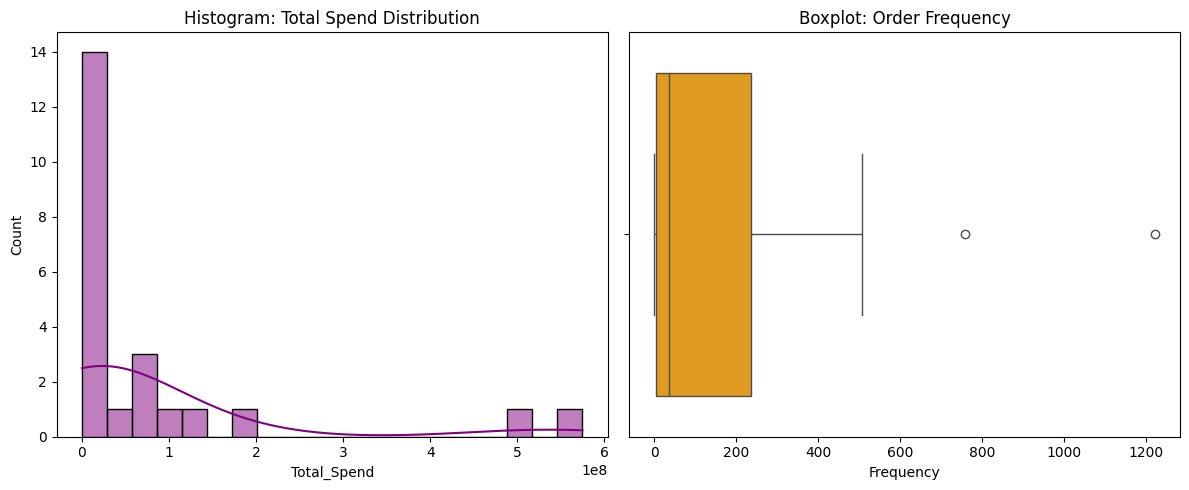

In [18]:

# 2. Histograms and boxplots (3 Marks)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(customer_df['Total_Spend'], bins=20, kde=True, color='purple')
plt.title('Histogram: Total Spend Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(x=customer_df['Frequency'], color='orange')
plt.title('Boxplot: Order Frequency')
plt.tight_layout()
plt.show()

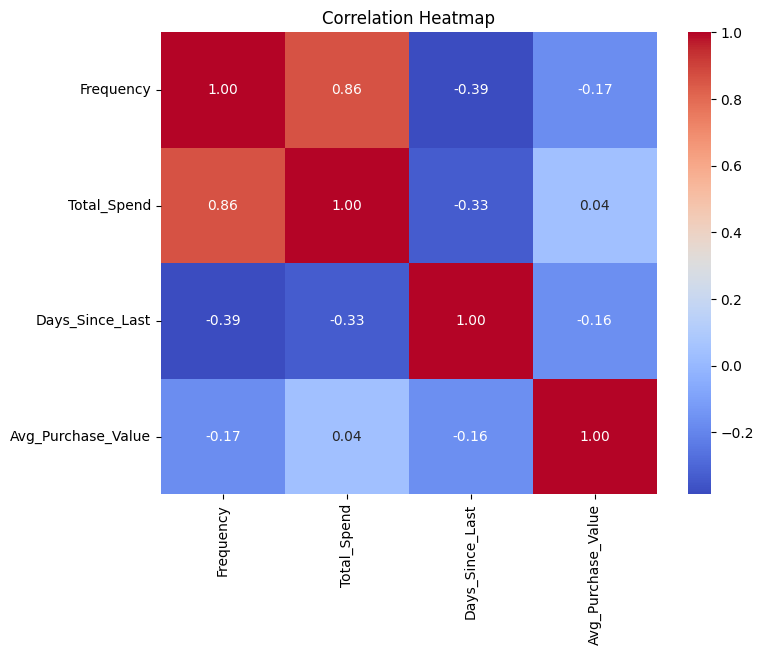

In [9]:
# 3. Correlation heatmap 
plt.figure(figsize=(8, 6))
corr = customer_df[['Frequency', 'Total_Spend', 'Days_Since_Last', 'Avg_Purchase_Value']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [10]:

# 4. Interpretation (2 Marks)
print("\n4. Interpretation:")
print("- High correlation usually exists between Frequency and Total Spend.")
print("- 'Days Since Last' usually correlates negatively with Spend (churned customers spend less).")
print("- Boxplots likely show outliers: a few 'Whales' spending significantly more than average.")



4. Interpretation:
- High correlation usually exists between Frequency and Total Spend.
- 'Days Since Last' usually correlates negatively with Spend (churned customers spend less).
- Boxplots likely show outliers: a few 'Whales' spending significantly more than average.


In [11]:
# ==========================================
# PART C: Feature Engineering
# ==========================================
print("\n--- PART C: FEATURE ENGINEERING ---")

# 1. Create two derived features 
# Feature A: Loyalty Index = Frequency * Avg Purchase Value
customer_df['Loyalty_Index'] = customer_df['Frequency'] * customer_df['Avg_Purchase_Value']

# Feature B: Recency Score (Days since last purchase)
# We keep the raw days for clustering, but create a 'Score' (1-5) for business logic
# 5 = Very Recent, 1 = Very Old
try:
    customer_df['Recency_Score'] = pd.qcut(customer_df['Days_Since_Last'], 5, labels=[5, 4, 3, 2, 1])
except ValueError:
    customer_df['Recency_Score'] = 1 # Fallback if not enough data points

# 2. Justify importance (2 Marks)
print("\n2. Feature Justification:")
print("- Loyalty Index: Combines how often they buy with how much they spend. High index = VIP.")
print("- Recency Score: Crucial for retention. High score means they are active now. Low score means risk of churn.")


--- PART C: FEATURE ENGINEERING ---

2. Feature Justification:
- Loyalty Index: Combines how often they buy with how much they spend. High index = VIP.
- Recency Score: Crucial for retention. High score means they are active now. Low score means risk of churn.



--- PART D: CLUSTERING MODELLING ---


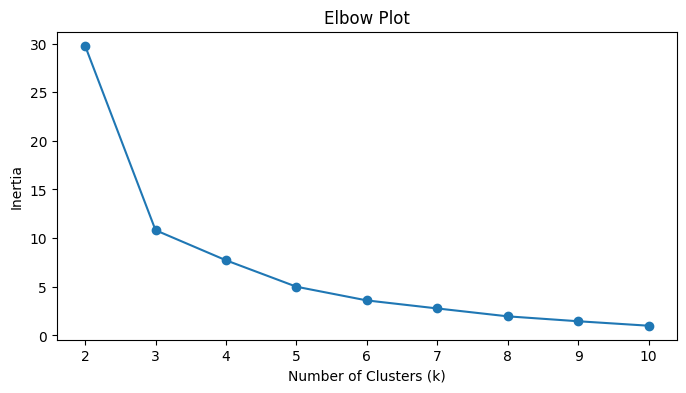

In [12]:
# ==========================================
# PART D: Clustering Modelling (10 Marks)
# ==========================================
print("\n--- PART D: CLUSTERING MODELLING ---")

# Preparing data for clustering (Use Standard Scaling for K-Means)
# We use Recency (Days), Frequency, and Monetary (Loyalty Index essentially)
X = customer_df[['Days_Since_Last', 'Frequency', 'Loyalty_Index']]
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

# 1. Apply K-Means for k=2 to 10 (2 Marks)
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 2. Generate Elbow Plot (2 Marks)
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [13]:
# 3. Select optimal k (2 Marks)
optimal_k = 4
print(f"\n3. Selected Optimal k = {optimal_k} (Elbow usually bends at 3 or 4).")

# Apply Final Clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans_final.fit_predict(X_scaled)


3. Selected Optimal k = 4 (Elbow usually bends at 3 or 4).


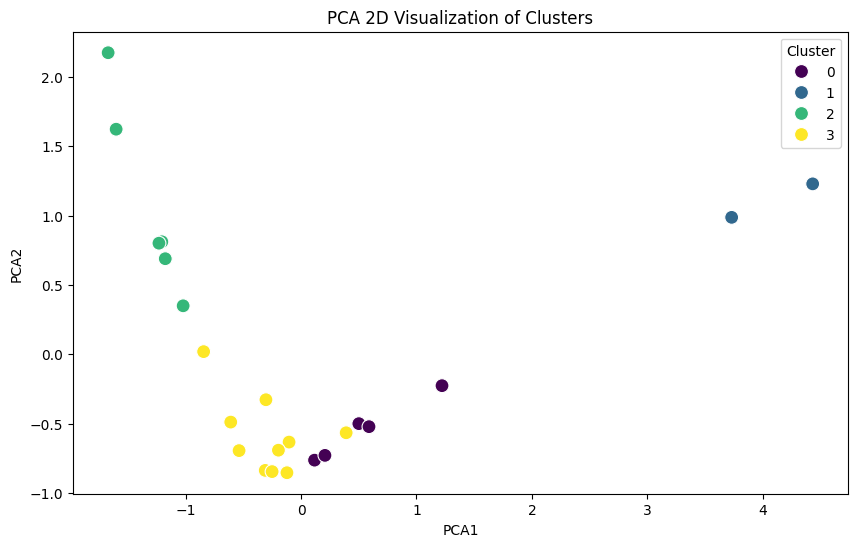

In [14]:
# 4. PCA 2D Visualisation (2 Marks)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
customer_df['PCA1'] = pca_components[:, 0]
customer_df['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_df, palette='viridis', s=100)
plt.title('PCA 2D Visualization of Clusters')
plt.show()

In [15]:
summary = customer_df.groupby('Cluster')[['Days_Since_Last', 'Frequency', 'Loyalty_Index']].mean()
print("\n5. Cluster Profile Summary (Averages):")
print(summary)


5. Cluster Profile Summary (Averages):
         Days_Since_Last   Frequency  Loyalty_Index
Cluster                                            
0               0.600000  301.000000   6.387138e+07
1               0.000000  990.500000   5.360106e+08
2              72.166667    9.666667   3.244462e+06
3               9.500000   38.400000   3.722004e+07


In [16]:
customer_df.to_csv('clustering_results.csv', index=False)
print("\nData saved to 'clustering_results.csv")


Data saved to 'clustering_results.csv
